In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.utils.data import DataLoader
from skimage.metrics import structural_similarity as ssim
import numpy as np

In [41]:
IMG_SIZE = 64
IMG_CHANNELS = 1
NUM_CLASSES = 14
LATENT_DIM = 128
EMBEDDING_DIM = 1
BATCH_SIZE = 64
CRITIC_ITERS = 3
LAMBDA_GP = 10
EPOCHS = 200
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PNEUMONIA_LABEL = 6

In [42]:
import torch.nn.utils.spectral_norm as spectral_norm

class Generator(nn.Module):
    def __init__(self, latent_dim=128, img_channels=1, img_size=64):
        super(Generator, self).__init__()
        self.init_size = img_size // 4
        self.fc = nn.Linear(latent_dim, 128 * self.init_size * self.init_size)

        self.model = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            spectral_norm(nn.Conv2d(128, 128, 3, stride=1, padding=1)),  # SN applied
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            spectral_norm(nn.Conv2d(128, 64, 3, stride=1, padding=1)),   # SN applied
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            spectral_norm(nn.Conv2d(64, img_channels, 3, stride=1, padding=1)),  # SN applied
            nn.Tanh()
        )

    def forward(self, z):
        out = self.fc(z).view(z.size(0), 128, self.init_size, self.init_size)
        img = self.model(out)
        return img


In [43]:
class Critic(nn.Module):
    def __init__(self, img_channels=1):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(img_channels, 64, 4, stride=2, padding=1)),   # 64x32x32
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(64, 128, 4, stride=2, padding=1)),            # 128x16x16
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(128, 256, 4, stride=2, padding=1)),           # 256x8x8
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(256, 1, 8)),                                  # 1x1x1
            nn.Flatten(),                                                        # (B, 1)
        )

    def forward(self, img):
        return self.model(img)


In [44]:
import torch
import torch.nn.functional as F
import torch.optim as optim

def compute_gradient_penalty(critic, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(real_samples.device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = critic(interpolates)
    fake = torch.ones_like(d_interpolates)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


In [45]:
from torchvision.transforms.functional import hflip, to_tensor
from torch.utils.data import Dataset, ConcatDataset
import torch
from medmnist import ChestMNIST

class PneumoniaDataset(Dataset):
    def __init__(self, base_dataset, label_index=6, flip=False):
        self.base_dataset = base_dataset
        self.label_index = label_index
        self.flip = flip
        self.indices = [i for i in range(len(base_dataset)) if int(base_dataset[i][1][label_index]) == 1]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img, _ = self.base_dataset[real_idx]  # img is PIL.Image

        img = to_tensor(img)  # Now it's a tensor in [0, 1], shape (1, 64, 64)

        if self.flip:
            img = hflip(img)

        img = img * 2 - 1  # Normalize to [-1, 1]
        return img, 1  # dummy label

    
full_dataset = ChestMNIST(split='train', transform=None, download=True,size=64)
pneumonia_original = PneumoniaDataset(full_dataset, flip=False)
pneumonia_flipped = PneumoniaDataset(full_dataset, flip=True)

augmented_dataset = ConcatDataset([pneumonia_original, pneumonia_flipped])
pneumonia_loader = DataLoader(augmented_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [46]:
real_samples = []

for img_batch, _ in pneumonia_loader:
    img_batch = img_batch[:16]  # grab just one small batch
    img_batch = (img_batch + 1) / 2.0  # scale from [-1,1] to [0,1]
    real_samples = [img.squeeze().cpu().numpy() for img in img_batch]
    break  # only need a few


In [47]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import random

def compute_ssim_batch(gen_imgs, real_imgs, max_per_sample=5):
    """
    Compute average SSIM between each generated image and several real ones.
    Expects lists of numpy arrays (H, W), values in [0, 1].
    """
    scores = []
    for gen in gen_imgs:
        sampled_real = random.sample(real_imgs, k=min(max_per_sample, len(real_imgs)))
        score = np.mean([
            ssim(gen, real, data_range=1.0) for real in sampled_real
        ])
        scores.append(score)
    return np.mean(scores)


In [48]:
from scipy.linalg import sqrtm
import numpy as np

def calculate_activation_statistics(images):
    """
    Takes in a list/array of images (N, H, W) and returns mean and cov of flattened vectors.
    """
    images = np.array(images)
    images = images.reshape(images.shape[0], -1)  # Flatten (N, H*W)
    mu = np.mean(images, axis=0)
    sigma = np.cov(images, rowvar=False)
    return mu, sigma

def compute_fid_score(generated_imgs, real_imgs):
    """
    Computes Fréchet Inception Distance (FID) between two sets of images.
    Args:
        generated_imgs: list or np.array of generated images, each shape (H, W)
        real_imgs: list or np.array of real images, each shape (H, W)
    Returns:
        fid_value: scalar float
    """
    mu_gen, sigma_gen = calculate_activation_statistics(generated_imgs)
    mu_real, sigma_real = calculate_activation_statistics(real_imgs)

    # Calculate FID using Fréchet Distance
    diff = mu_gen - mu_real
    covmean, _ = sqrtm(sigma_gen.dot(sigma_real), disp=False)
    
    # Numerical stability
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma_gen + sigma_real - 2 * covmean)
    return fid


In [49]:
def train_wgan_gp(generator, critic, dataloader,
                  latent_dim=128, epochs=100,
                  lr=2e-4, lambda_gp=10,
                  critic_iters=5, device='cuda'):

    generator = generator.to(device)
    critic = critic.to(device)

    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.0, 0.9))
    optimizer_C = optim.Adam(critic.parameters(), lr=lr, betas=(0.0, 0.9))
    scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=25, gamma=0.9)
    scheduler_C = optim.lr_scheduler.StepLR(optimizer_C, step_size=25, gamma=0.9)

    best_ssim = -1
    best_fid = float("inf")

    for epoch in range(epochs):
        for i, (real_imgs, _) in enumerate(dataloader):
            real_imgs = real_imgs.to(device)

            # Train Critic
            for _ in range(critic_iters):
                z = torch.randn(real_imgs.size(0), latent_dim).to(device)
                fake_imgs = generator(z).detach()

                real_validity = critic(real_imgs)
                fake_validity = critic(fake_imgs)

                gp = compute_gradient_penalty(critic, real_imgs, fake_imgs)
                c_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp

                optimizer_C.zero_grad()
                c_loss.backward()
                optimizer_C.step()

            # Train Generator
            z = torch.randn(real_imgs.size(0), latent_dim).to(device)
            gen_imgs = generator(z)
            g_loss = -torch.mean(critic(gen_imgs))

            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

        # scheduler_G.step()
        # scheduler_C.step()

        # Evaluation
        with torch.no_grad():
            gen_test = generator(torch.randn(16, latent_dim).to(device))
            gen_test = (gen_test + 1) / 2
            gen_test_np = [img.squeeze().cpu().numpy() for img in gen_test]

            ssim_score = compute_ssim_batch(gen_test_np, real_samples[:16])
            fid_score = compute_fid_score(gen_test_np, real_samples[:16])  # Define separately

        if ssim_score > best_ssim:
            best_ssim = ssim_score
            torch.save(generator.state_dict(), "best_generator_ssim.pth")
            print(f"💾 Saved best SSIM generator at epoch {epoch+1}, SSIM: {ssim_score:.4f}")

        if fid_score < best_fid:
            best_fid = fid_score
            torch.save(generator.state_dict(), "best_generator_fid.pth")
            print(f"💾 Saved best FID generator at epoch {epoch+1}, FID: {fid_score:.4f}")

        print(f"[Epoch {epoch+1}/{epochs}] Generator Loss: {g_loss.item():.4f}, Critic Loss: {c_loss.item():.4f}, SSIM: {ssim_score:.4f}, FID: {fid_score:.2f}")

    torch.save(generator.state_dict(), "final_generator_wcgan.pth")


In [50]:
train_wgan_gp(
    generator=Generator(latent_dim=LATENT_DIM),
    critic=Critic(),
    dataloader=pneumonia_loader,
    latent_dim=LATENT_DIM,
    epochs=EPOCHS,
    critic_iters=CRITIC_ITERS,
    device=DEVICE
)


💾 Saved best SSIM generator at epoch 1, SSIM: 0.1097
💾 Saved best FID generator at epoch 1, FID: 227.7937
[Epoch 1/200] Generator Loss: -10.1672, Critic Loss: -19.0633, SSIM: 0.1097, FID: 227.79
💾 Saved best SSIM generator at epoch 2, SSIM: 0.1363
💾 Saved best FID generator at epoch 2, FID: 145.1965
[Epoch 2/200] Generator Loss: -13.2474, Critic Loss: -12.5027, SSIM: 0.1363, FID: 145.20
💾 Saved best SSIM generator at epoch 3, SSIM: 0.1864
💾 Saved best FID generator at epoch 3, FID: 122.9030
[Epoch 3/200] Generator Loss: -13.0349, Critic Loss: -9.6911, SSIM: 0.1864, FID: 122.90
💾 Saved best SSIM generator at epoch 4, SSIM: 0.2408
💾 Saved best FID generator at epoch 4, FID: 108.5217
[Epoch 4/200] Generator Loss: -9.5787, Critic Loss: -7.1069, SSIM: 0.2408, FID: 108.52
💾 Saved best SSIM generator at epoch 5, SSIM: 0.2435
💾 Saved best FID generator at epoch 5, FID: 95.7845
[Epoch 5/200] Generator Loss: -3.5261, Critic Loss: -6.0251, SSIM: 0.2435, FID: 95.78
💾 Saved best SSIM generator at e

KeyboardInterrupt: 

In [54]:
generator = Generator().to(DEVICE)
generator.load_state_dict(torch.load("best_generator_ssim.pth"))
generator.eval()


Generator(
  (fc): Linear(in_features=128, out_features=32768, bias=True)
  (model): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

In [55]:
import matplotlib.pyplot as plt

# Generate random noise
z = torch.randn(16, LATENT_DIM).to(DEVICE)
labels = torch.full((16,), PNEUMONIA_LABEL, dtype=torch.long).to(DEVICE)

# Generate images
with torch.no_grad():
    gen_imgs = generator(z).cpu()


# Convert from [-1, 1] → [0, 1]
gen_imgs = (gen_imgs + 1) / 2


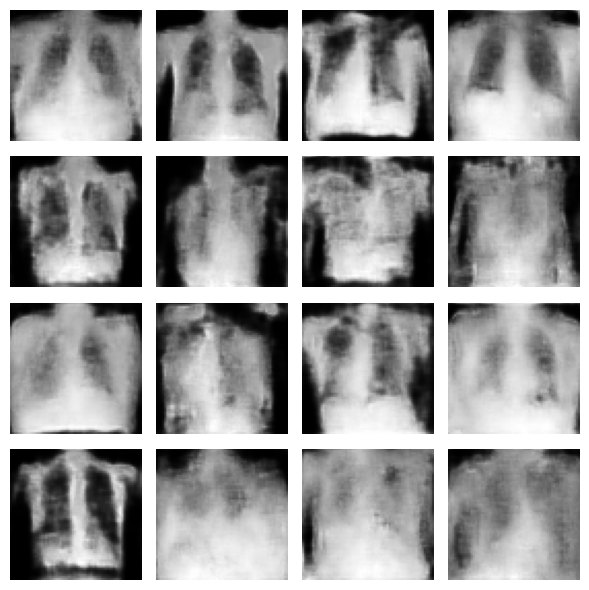

In [56]:
# Plot a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(gen_imgs[i][0], cmap='gray')
    ax.axis("off")
plt.tight_layout()
plt.show()
